In [1]:
# https://www.robots.ox.ac.uk/~vgg/data/pets/ adresinden annotations.tar.gz ve images.tar.gz indirip ayıkladık

import os

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import random

from tensorflow import keras
import numpy as np
from tensorflow.keras import layers

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160,160)
num_classes = 4

input_img_paths = sorted(
    [
        os.path.join(input_dir,fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

print(input_img_paths)


target_img_paths = sorted(
    [
        os.path.join(target_dir,fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print(target_img_paths)

print("Number of samples:", len(input_img_paths))




['images/Abyssinian_1.jpg', 'images/Abyssinian_10.jpg', 'images/Abyssinian_100.jpg', 'images/Abyssinian_101.jpg', 'images/Abyssinian_102.jpg', 'images/Abyssinian_103.jpg', 'images/Abyssinian_104.jpg', 'images/Abyssinian_105.jpg', 'images/Abyssinian_106.jpg', 'images/Abyssinian_107.jpg', 'images/Abyssinian_108.jpg', 'images/Abyssinian_109.jpg', 'images/Abyssinian_11.jpg', 'images/Abyssinian_110.jpg', 'images/Abyssinian_111.jpg', 'images/Abyssinian_112.jpg', 'images/Abyssinian_113.jpg', 'images/Abyssinian_114.jpg', 'images/Abyssinian_115.jpg', 'images/Abyssinian_116.jpg', 'images/Abyssinian_117.jpg', 'images/Abyssinian_118.jpg', 'images/Abyssinian_119.jpg', 'images/Abyssinian_12.jpg', 'images/Abyssinian_120.jpg', 'images/Abyssinian_121.jpg', 'images/Abyssinian_122.jpg', 'images/Abyssinian_123.jpg', 'images/Abyssinian_124.jpg', 'images/Abyssinian_125.jpg', 'images/Abyssinian_126.jpg', 'images/Abyssinian_127.jpg', 'images/Abyssinian_128.jpg', 'images/Abyssinian_129.jpg', 'images/Abyssinian

In [2]:
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


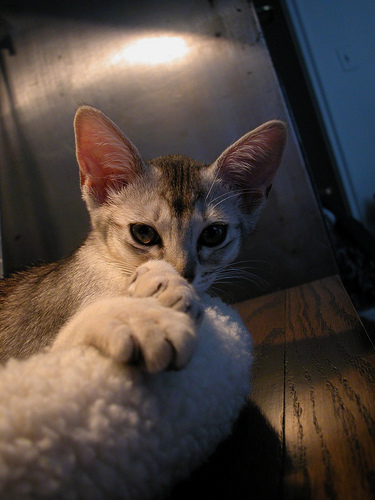

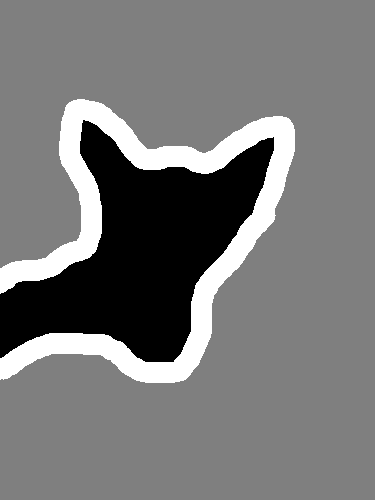

In [3]:
display(Image(filename=input_img_paths[1]))

#display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[1]))
display(img)
#2.resim anlamsal bölütlemenin yapılmış hali. Daha doğrusu anlamsal bölütlemenin olması beklenen hedef hali. Buna ground truth diyoruz.

In [4]:
#datasetimizi okuyacak olan loader'ımızı yazıyoruz

class OxfordPets(keras.utils.Sequence):
    """helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self,idx): # her yeni resim istediğinde bu fonksiyonu çalıştırıyor, input_img_paths içindeki sıradaki resmi getiriyo
        """Returns tuple (input, target) correspond to batch #idx. """
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,) , dtype = "float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size= self.img_size)
            x[j] = img

        y = np.zeros((batch_size,) + self.img_size + (1,) , dtype = "uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size= self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

In [5]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size +(3,))

    ###[First half of the network: downsampling inputs] ###

    #Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x # Set aside residual

    #Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64,128,256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x) 
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x) 
        x = layers.BatchNormalization()(x)

        x= layers.MaxPooling2D(3, strides=2, padding="same")(x)

        #Project Residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual]) # Add back residual
        previous_block_activation = x # Set aside next residual


    ###[Second half of the network: upsampling inputs] ###

    for filters in [256,128,64,32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x) 
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x) 
        x = layers.BatchNormalization()(x)

        x= layers.UpSampling2D(2)(x)

        #Project Residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual]) # Add back residual
        previous_block_activation = x # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    #Define the model
    model = keras.Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

#Build model
model = get_model(img_size, num_classes)
model.summary()
"""Output_shape kısmındaki None'lar batch size'ı ifade ediyor, sondaki sayı derinlik
activation_8 sırasında sıkıştırma işlemi bittikten sonra resim orijinal boyutuna gelene kadar büyütülüyor
"""

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 80,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 80, 80,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 80, 80,    │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 80, 80,    │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 40, 40,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 40, 40,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 40, 40,    │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 40, 40,    │          0 │ batch_normalizat

 Total params: 2,059,268 (7.86 MB)

 Trainable params: 2,055,492 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

"Output_shape kısmındaki None'lar batch size'ı ifade ediyor, sondaki sayı derinlik\nactivation_8 sırasında sıkıştırma işlemi bittikten sonra resim orijinal boyutuna gelene kadar büyütülüyor\n"

In [6]:
batch_size = 32
#split or img_paths into a training and a validation set
val_samples = 500 #500 tane veri validation için ayrıldı
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[: -val_samples]
train_target_img_paths = target_img_paths[: -val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

#instantiate data Sequences for each split
train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [8]:
#Configure the model for training.
#We use the "sparse" version of categorical_crossentropy
#because uor target data is integers.
model.compile(optimizer="SGD", loss = "sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only= True)
]

#Train the model, doing validation at the end of each epoch.
epochs = 15

#model = keras.models.load_model("oxford_segmentation.h5")

model.fit(train_gen, epochs= epochs, validation_data= val_gen, callbacks= callbacks)

Epoch 1/15


c:\Users\kubra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


215/215 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - loss: 2.4765 - val_loss: 1.7817
Epoch 2/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - loss: 0.7002 - val_loss: 1.8694
Epoch 3/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - loss: 0.6628 - val_loss: 0.7723
Epoch 4/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - loss: 0.6326 - val_loss: 0.6046
Epoch 5/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - loss: 0.6092 - val_loss: 0.5854
Epoch 6/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - loss: 0.5892 - val_loss: 0.5881
Epoch 7/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - loss: 0.5737 - val_loss: 0.5635
Epoch 8/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - loss: 0.5642 - val_loss: 0.5804
Epoch 9/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - loss: 0.5498 - val_loss: 0.5652
Epoch 10/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - loss: 0.5425 - val_loss: 0.6289
Epoch 11/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - loss: 0.5306 - val_loss: 0.6769
Epoch 12/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/ste

c:\Users\kubra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 381ms/step


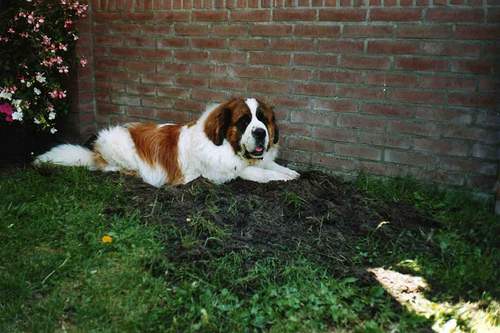

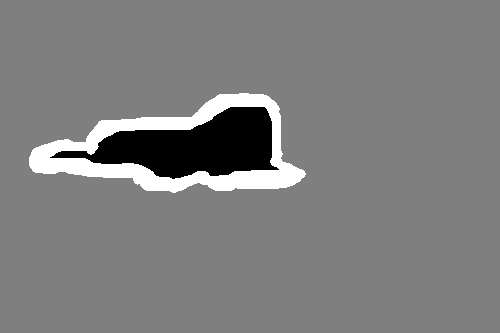

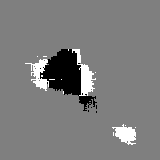

In [9]:
#Generate predictions for all images in the validation set




val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
model = keras.models.load_model("oxford_segmentation.keras")
val_preds = model.predict(val_gen)

def display_mask(i):
    """quick utility to display a model's prediction"""
    mask = np.argmax(val_preds[i], axis= -1)
    mask = np.expand_dims(mask, axis = -1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

#Display results for validation image
i = 203

#display input image
display(Image(filename=val_input_img_paths[i]))

#display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

#display mask predicted by our model
display_mask(i) #note that the model only sees input at 150x150.